**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [297]:
# write your code here
import numpy as np
import pandas as pd
from copy import copy
from types import SimpleNamespace
import sympy as sm
from scipy import optimize
import matplotlib.pyplot as plt


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor



The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [298]:
bl = SimpleNamespace()

bl.alpha = 0.5
bl.kappa = 1.0
bl.nu = 1/(2*16**2)
bl.w = 1
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w

In [299]:
import numpy as np
import scipy.optimize as optimize

# Given list of G values
G_list = [1.0, 2.0]

# Calculate bl.w_tilde
bl.w_tilde = (1 - bl.tau) * bl.w

# Define value function
def V(L, G, bl):
    """
    Calculates the value function.

    Args:
        L (float): Labor input.
        G (float): G value.
        bl: An object with parameters.

    Returns:
        float: Value function output.
    """
    return np.log(((bl.kappa + (1 - bl.tau) * bl.w * L) ** bl.alpha) * G ** (1 - bl.alpha)) - bl.nu * ((L * L) / 2)

def L_opt_analytical(bl, G):
    """
    Calculates the analytical solution for optimal labor input.

    Args:
        bl: An object with parameters.
        G (list): List of G values.

    Returns:
        list: List of optimal labor inputs.
    """
    L_opt = []
    for k in G:
        L_opt.append((-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde))
    return L_opt

def L_opt(G, bl):
    """
    Calculates the numerical solution for optimal labor input.

    Args:
        G (list): List of G values.
        bl: An object with parameters.

    Returns:
        list: List of optimal labor inputs.
    """
    sol = []
    for k in G:
        obj = lambda L: -V(L, k, bl)
        x0 = 12
        sol.append(optimize.minimize(obj, x0, method='Nelder-Mead', bounds=((0, 24),)).x[0])
    return sol

# Calculate numerical solutions for optimal labor input
solutions = L_opt(G_list, bl)
solution = list(solutions)

# Calculate analytical solutions for optimal labor input
solution_analytical = L_opt_analytical(bl, G_list)

# Print the results
print(f"The estimated solutions for G=1 and G=2, respectively, are {solution}")
print(f"The analytical solutions for G=1 and G=2, respectively, are {solution_analytical}")


The estimated solutions for G=1 and G=2, respectively, are [15.301684570312506, 15.301684570312506]
The analytical solutions for G=1 and G=2, respectively, are [15.30165022719559, 15.30165022719559]


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

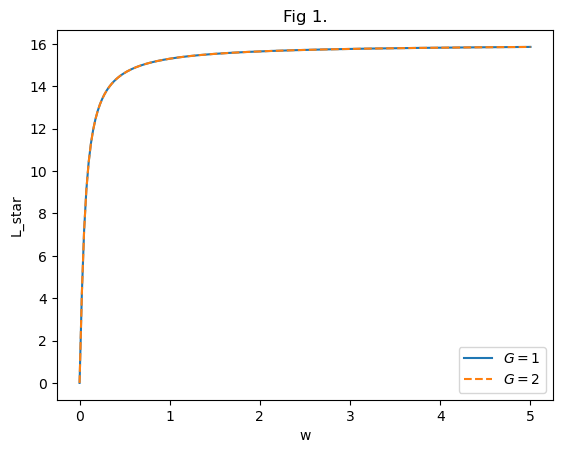

In [300]:


# Create grids
ws = np.linspace(0,5,200)
sols = np.empty((2,200))
sol_1 = np.empty(200)
sol_2 = np.empty(200)

#Unpack solution for each G
for i,w in enumerate(ws):
    bl.w = w
    sols = L_opt(G_list, bl)
    sols_list = list(sols)
    sol_1[i] = sols_list[0]
    sol_2[i] = sols_list[1]

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ws,sol_1, label = '$G=1$')
ax.plot(ws,sol_2,'--', label = '$G=2$')

ax.set_title("Fig 1.")
ax.set_ylabel('L_star')
ax.set_xlabel('w')
ax.legend()






We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


/var/folders/f8/rfv2dg5j1jl2h__f_28lykhm0000gn/T/ipykernel_94871/1329729795.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


(0.0, 4.0)

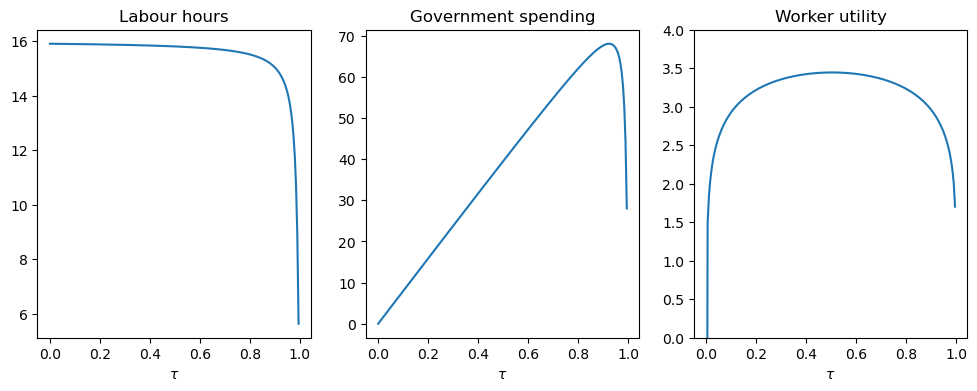

In [301]:
# Define G
def G_func(L, bl): return bl.tau*bl.w*L

# Define analytical solution with definition for G substituted
def L_analytical_func(bl): 
    return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)

# Define Value function with definition for G substituted
def V_new(L,bl):
    return np.log(((bl.kappa + (1 - bl.tau) * bl.w * L) ** bl.alpha) * (bl.tau*bl.w*L) ** (1 - bl.alpha)) - bl.nu * ((L * L) / 2)


def iterate_over_tau(bl, do_print = False):

    # Create grid of taus and empty arrays
    tau_grid = np.linspace(1e-8,1,200)
    L_vec = np.empty(200)
    G_vec = np.empty(200)
    V_vec = np.empty(200)

    # Iterate L, G and V over tau
    for i, tau in enumerate(tau_grid):
        bl.tau = tau 
        bl.w_tilde = (1-bl.tau)*bl.w

        L_vec[i] = L_analytical_func(bl)
        G_vec[i] = G_func(L_vec[i], bl)
        V_vec[i] = V(L_vec[i], G_vec[i], bl) 

        if do_print == True: 
            print(f'for tau = {tau}, L = {L_vec[i]}, G = {G_vec[i]} and V = {V_vec[i]}')

    return tau_grid, L_vec, G_vec, V_vec 

tau_grid, L_vec, G_vec, V_vec = iterate_over_tau(bl)    


# Plot figures
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
ax.plot(tau_grid, L_vec)
ax.set_title('Labour hours')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,2)
ax.plot(tau_grid, G_vec)
ax.set_title('Government spending')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,3)
ax.plot(tau_grid, V_vec)
ax.set_title('Worker utility')
ax.set_xlabel(r'$\tau$')
ax.set_ylim(0,4)

    

 


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

/var/folders/f8/rfv2dg5j1jl2h__f_28lykhm0000gn/T/ipykernel_94871/1329729795.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


Text(0.5, 1.0, 'Fig 3. Socially optimal tax')

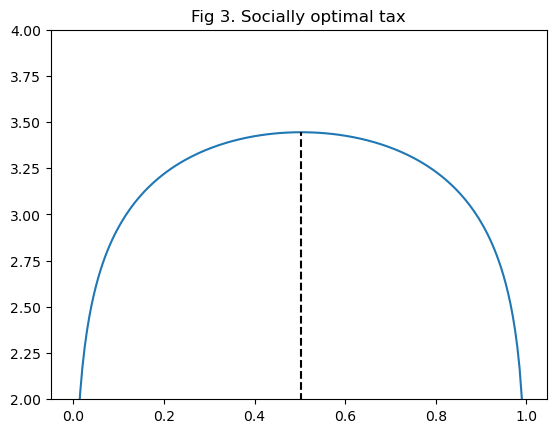

In [303]:
# Identify the maximum V and find the corresponding tau
tau_grid, L_vec, G_vec, V_vec = iterate_over_tau(bl)   
argmax_index = np.argmax((np.nan_to_num(V_vec)))
tau_opt  = tau_grid[argmax_index]

# Illustrate in figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_grid, V_vec)
ax.vlines(tau_opt,0,np.max(np.nan_to_num(V_vec)), linestyles='--', colors='black')
ax.set_ylim(2,4)
ax.set_title('Fig 3. Socially optimal tax')



A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [428]:
bl.sigma = 1.001
bl.rho = 1.001
bl.w = 1.0

# bl.sigma = [1.001, 1.5]
# bl.rho = [1.001, 1.5]

bl.eps = 1
tau_grid, L_vec, G_vec, V_vec = iterate_over_tau(bl)   
argmax_index = np.argmax((np.nan_to_num(V_vec)))
tau_opt  = tau_grid[argmax_index]

print(tau_opt)

def calculate_C(bl, L, tau=tau_opt):
    return bl.kappa + (1 - tau) * bl.w * L

def calculate_G(bl, L, tau=tau_opt):
    # print(bl.tau,bl.w, L)
    return tau*bl.w*L


def objective_function(L, bl, G):
    C = calculate_C(bl, L)
    # G = calculate_G(bl,L)
    term1 = ((bl.alpha * C**((bl.sigma - 1) / bl.sigma) + (1 - bl.alpha) * G**((bl.sigma -1) / bl.sigma))**(bl.sigma / (bl.sigma-1)))**(1 - bl.rho) - 1
    term2 = bl.nu * L**(1 + bl.eps) / (1 + bl.eps)
    return -(term1 / (1 - bl.rho) - term2)

def solve_for_given_G(bl,G):

    bl.tau = tau_opt
    bl.w = 1.0
    # Define the bounds for L
    L_bounds = (1e-8, 24.0)

    # Set the initial guess for L
    x0 = 1.0

    # Define the optimization problem
    res = optimize.minimize(objective_function, x0, method = 'Nelder-Mead', args=(bl,G), bounds=([L_bounds]))    

    G_res = calculate_G(bl, res.x[0])
    
    # Return the optimal value of L
    return res



def find_opt_G(bl,tau=tau_opt, do_print = False):
    Gs = np.linspace(0e-16,20,2000)
    Ls = np.empty(2000)
    diffs = np.empty(2000)
    

    for i, g in enumerate(Gs):
        res = solve_for_given_G(bl,g)
        Ls[i] = res.x
        diffs[i] = g - tau*bl.w*Ls[i]
        
        utility = res.fun

        if do_print is True: print(f'for G = {g} --> L = {Ls[i]} and diff = {diffs[i]}')

    return Gs, Ls, diffs, utility

par_list =[1.001,1.5]

for i in [0,1]:
    bl.rho, bl.sigma = par_list[i]
    Gs, Ls, diffs, utility = find_opt_G(bl)
    print(f'for rho, sigma = {i}')
    print(f'G = {Gs[np.argmin(np.abs(diffs))]} corresponds to L = {Ls[np.argmin(np.abs(diffs))]}'
      ,f' and minimizes the difference G - tau_opt*w*L = {np.min(np.abs(diffs))}')


fig, ax = plt.subplots(1,1)
ax.plot(Gs, diffs, label = 'Difference')
ax.hlines(0, xmin=0, xmax=20, colors='black')
ax.vlines(Gs[np.argmin(np.abs(diffs))], ymin=-5, ymax=16, linestyles="--", colors='red', label='Argmin')
ax.set_ylim(-5,10)
ax.legend()

0.5125628189447237


/var/folders/f8/rfv2dg5j1jl2h__f_28lykhm0000gn/T/ipykernel_94871/1329729795.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


TypeError: cannot unpack non-iterable float object

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [306]:
# write your code here  

taus = np.linspace(1e-8, 1,100)

def find_opt_tau(bl, do_print = False):
    Gs = np.linspace(0e-16,20,2000)
    Ls = np.empty(2000)
    diffs = np.empty(2000)
    uti_grid = np.empty(2000)
    
    for i, g in enumerate(Gs):
        res = solve_for_given_G(bl,g)
        Ls[i] = res.x
        diffs[i] = g - tau*bl.w*Ls[i]
        
        uti_grid[i] = res.fun

        if do_print is True: print(f'for G = {g} --> L = {Ls[i]} and diff = {diffs[i]}')

    return Gs, Ls, diffs, utility



## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [307]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [308]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [309]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [310]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [311]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [312]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [313]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [314]:
# write your code here